# <Center>  **Exploratory Data Analysis**

## Loading Data and Packages

Import Packages

In [2]:
# Import the Data Science Essentials
import pandas as pd
import numpy as np
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.image as im
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
from IPython import display
from kmodes.kprototypes import KPrototypes

from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm



plt.style.use('dark_background')

Set Directory to Capstone-2 folder to make everything simple.

In [3]:
# Find and set the working directory for this project
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

Load the Data

In [4]:
# Import the data
data = pd.read_csv('./data/processed/KDD Data.csv')
data = data.drop('Unnamed: 0', axis = 1)

## Basic Analysis

Many of the names of the features in this dataset are not intuitive, so I will define them all:
- **wrong_fragment:** number of fragments of code that were corrupted or out of order with the other code that was recieved
    - continuous
- **hot:** number of indicators	that suggest a problem
    - continuous
- **count:** number of connections to the same host as the current connection in the past two seconds 	
    - continuous
- **srv_diff_host_rate:** % of connections to different hosts in the last 2 seconds	
    - continuous 
- **dst_host_count:** number of connections to the same host as the current connection in the last 100 connections.
    - continuous.
- **protocol_type_udp:** dummy variable that has two values from StandardScaler for Lasso. Higher value if udp protocol is used. Lower value if udp is not used  	
    - discrete [-0.20729498,  4.82404356]
- **service_eco_i:** dummy variable that has two values from StandardScaler for Lasso. Higher value if service_eco_i is used. Lower value if eco_i is not used 	
    - discrete [-0.05774804, 17.31660472]
- **service_ftp_data** dummy variable that has two values from StandardScaler for Lasso. Higher value if service_ftp_data is used. Lower value if ftp_data is not used
    - discrete [-0.09822676, 10.18052475]
- **service_smtp:** dummy variable that has two values from StandardScaler for Lasso. Higher value if service_smtp is used. Lower value if smtp is not used
    - discrete  [-0.14169165,  7.05757897]  
- **flag_RSTR:** dummy variable that has two values from StandardScaler for Lasso. Higher value if flag_RSTR is used. Lower value if RSTR is not used 	 
    - discrete [-0.04279262, 23.36851485]
- **Syn Error:** Max of all the columns that refer to Syn Ack error of the threeway handshake protocol. The amalgamation is to avoid multicolinearity.
    - Continuous
- **Rej Error:** Max of all the columns that refer to the connection rejection error. The amalgamation is to avoid multicolinearity.
    - Continuous



The label column gives us the kind of intrusion. These intrusion types are also not obvious to understand without prior knowledge in this area. As such, I consulted a more well read source, ChatGPT. I formatted the the query in the python cell below by creating a python output that was in bullet form, then I inputed it into chatGPT which was able to give really good definitions to labels that were not even clear attack types.

In [ ]:
# Create a loop over all the different attack types
for type in data['labels'].unique():
    # Print out the attack types in bullet format to make the next section easier
    print(f"- {type}")

After plugging the above list into ChatGPT with the query "For each of these network intrusions can you please give a sentence summary describing what they are." ChatGPT returned these explanations for each of the network intrusion types
- **normal:** This is not an attack type, but rather a classification used to indicate that the network traffic is within normal parameters.
- **buffer_overflow:** This attack occurs when a program or process attempts to store more data in a buffer than it was intended to hold, causing the excess data to overflow into adjacent memory locations.
- **loadmodule:** This type of attack involves the unauthorized loading of a module or plugin into a vulnerable system, which can then be used to gain further access or control over the system.
- **perl:** This is a type of attack that involves exploiting vulnerabilities in Perl scripts, which are often used to power web applications and other online services.
- **neptune:** This attack type involves overwhelming a targeted system with a flood of TCP packets, causing it to become unresponsive or crash.
- **smurf:** This attack type is similar to the neptune attack, but involves using a network of intermediary hosts to amplify the volume of traffic directed at the target system.
- **guess_passwd:** This attack type involves attempting to guess a user's password by systematically trying a large number of possible combinations.
- **pod:** This attack type involves sending malformed packets to a target system in order to cause it to crash or become unstable.
- **teardrop:** This is a type of attack that involves sending overlapping or malformed packets to a target system, causing it to crash or become unstable.
- **portsweep:** This attack involves scanning a range of network ports on a target system to identify potential vulnerabilities or open services.
- **ipsweep:** This attack involves scanning a range of IP addresses to identify potential targets for further attacks or exploitation.
- **land:** This attack type involves sending TCP packets with the source IP address set to the same as the destination IP address, causing the targeted system to become unresponsive or crash.
- **ftp_write:** This attack involves gaining unauthorized access to an FTP server and uploading or modifying files on the server.
- **back:** This type of attack involves installing backdoor software on a targeted system, which can then be used to gain unauthorized access or control over the system at a later time.
- **imap:** This attack involves exploiting vulnerabilities in the Internet Message Access Protocol (IMAP), which is commonly used for retrieving email messages.
- **satan:** This is a type of network scanning tool that can be used to identify potential vulnerabilities or open services on a target system.
- **phf:** This attack involves exploiting vulnerabilities in the Common Gateway Interface (CGI) scripts that are often used to power web applications and other online services.
- **nmap:** This is another type of network scanning tool that can be used to identify potential vulnerabilities or open services on a target system.
- **multihop:** This type of attack involves using a chain of intermediary hosts to mask the origin of the attack and make it more difficult to trace back to the attacker.
- **warezmaster:** This attack type involves using a compromised system to distribute pirated software or other illegal materials.
- **warezclient:** This attack involves using a compromised system to download pirated software or other illegal materials.
- **spy:** This type of attack involves monitoring or eavesdropping on network traffic in order to steal sensitive information or gain unauthorized access to a targeted system.
- **rootkit:** This is a type of malware that is designed to hide its presence on a targeted system, making it more difficult to detect or remove.

At first glance the different types of intrusions clearly fall into separate groups. On the original challenge's [webpage](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) the contest makers list 4 distinct groups:
- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
- probing: surveillance and other probing, e.g., port scanning.

This makes sense. For example, portsweep and ipsweep are clearly in the probing group as they are types of sweeps that search for vulnerabilities. 

But we can't assume that intrusions of the same kind should be grouped together. It could be that a hacker would use ipsweep as a first step in a ping of death (pod) attack, while rarely ever using an ipsweep and portsweep in the same attack together. Without clear information on how to group the different intrusions, we need to use cluster analysis to provide a more rigorous analysis.

## Creating Clusters

This dataset has both categorical and numerical data types. K-Prototypes is a clustering algorithm that was designed to handle mixed data types. We do not know the number of clusters that are in the data so we will graph K-Prototype's dissimilarity vs the amounnt of clusters (K) to find the optimal number of clusters. 

I also came up with my own grouping that has more specific groups than the competitions list of four. While the competition's grouping made sense, I thought that a method specific approach would be another potentially valid grouping. 

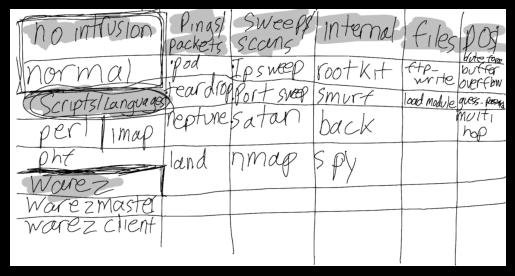

In [15]:
img = im.imread(r'./notebooks/Supernote/Potential Cluster Groupings.png');
fig, ax = plt.subplots()
ax.imshow(img);
ax.axis('off')
plt.show();

My handwriting isn't great, All the highlighted cells are names of my groupings.

The next cell is processing the data so that it only has independent variables and has the categorical columns as type categorical.

In [4]:
#Remove the y from the dataframe so the result is not influence by it
X = pd.read_csv('./data/interim/features.csv')
# Drop the weird index
X = X.drop('Unnamed: 0', axis = 1)

# Create list of categorical columns including binary in a list comprehension. 
cat_col = [col for col in X.columns if len(X[col].unique()) == 2]

# Convert binary columns into categorical columns because they represent two states more so than degrees
X[cat_col] = X[cat_col].astype('category')

# Get the index of the categorical columns
cat_col_index = [list(X.columns).index(col) for col in cat_col]

After splitting up the different intrusions into categories represented by the highlighted boxes above, it appeared that there were 8 tentative categories based on a casual sort through the types. While there is nothing definitive about this grouping, it should give us an insight to put 8 clusters firmly within the range of the number of clusters that we should try. 

The formula for KPrototype in this cell is weighted between categorical and numeric columns as some of the features in the dataset are dummy variables from the same column. There are 12 columns in total, 5 dummy variables but three categorical variables that they came from. As such I will give categorical variables a weight of 3/10 as that is the amount of original variables there were 

In [5]:
x_data = data.drop(['labels'], axis = 1)
cats = ['service', 'flag', 'protocol_type']

cats_cols = []

for prefix in cats:
    cols = data.filter(regex=prefix).columns
    data[cols] = data[cols].astype('category')
    cols = list(data.columns.get_indexer(cols))
    cats_cols.extend(cols)
    

In [6]:
len(cats_cols)

58

In [7]:
len(x_data.columns)

79

In [9]:
3/(len(x_data.columns)- len(cats_cols) + 3)

0.125

In [10]:
x_data.head()

,service_iso_tsap,flag_S3,dst_host_count,Rej Error,num_failed_logins,flag_RSTO,service_domain,service_kshell,service_uucp,service_smtp,...,flag_S1,service_ntp_u,service_X11,protocol_type_udp,service_gopher,service_http_443,service_bgp,service_ldap,srv_diff_host_rate,service_csnet_ns
0,-0.015259,-0.004499,-3.297128,-0.247961,-0.009782,-0.034255,-0.015325,-0.014086,-0.01465,-0.141692,...,-0.010742,-0.027745,-0.004719,-0.207295,-0.015391,-0.014158,-0.01465,-0.0143,-0.203633,-0.015972
1,-0.015259,-0.004499,-3.142675,-0.247961,-0.009782,-0.034255,-0.015325,-0.014086,-0.01465,-0.141692,...,-0.010742,-0.027745,-0.004719,-0.207295,-0.015391,-0.014158,-0.01465,-0.0143,-0.203633,-0.015972
2,-0.015259,-0.004499,-2.988222,-0.247961,-0.009782,-0.034255,-0.015325,-0.014086,-0.01465,-0.141692,...,-0.010742,-0.027745,-0.004719,-0.207295,-0.015391,-0.014158,-0.01465,-0.0143,-0.203633,-0.015972
3,-0.015259,-0.004499,-2.833769,-0.247961,-0.009782,-0.034255,-0.015325,-0.014086,-0.01465,-0.141692,...,-0.010742,-0.027745,-0.004719,-0.207295,-0.015391,-0.014158,-0.01465,-0.0143,-0.203633,-0.015972
4,-0.015259,-0.004499,-2.679316,-0.247961,-0.009782,-0.034255,-0.015325,-0.014086,-0.01465,-0.141692,...,-0.010742,-0.027745,-0.004719,-0.207295,-0.015391,-0.014158,-0.01465,-0.0143,-0.203633,-0.015972


100%|██████████| 14/14 [15:59:23<00:00, 4111.68s/it]  


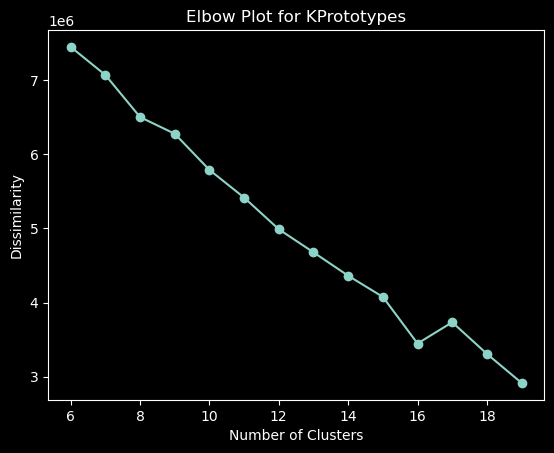

In [11]:
# Initialize cost list
cost = []

# Iterate for different amounts of centroids
for k in tqdm(range(6,20)):
    # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
    KProto = KPrototypes(n_clusters = k, init = 'Cao', n_init = 10, gamma = 0.125,  verbose = 0, n_jobs = -1)
    # Use the KPrototypes model on the actual data
    cluster_labels = KProto.fit_predict(x_data, categorical = cats_cols)
    # Append cost to the cost list for graphing later
    cost.append(KProto.cost_) 

# An elbow plot of k vs the cost function to try to find the optimal k
plt.plot(range(6,20), cost, marker = 'o');
# Label the x-axis
plt.xlabel('Number of Clusters');
#label the y-axis
plt.ylabel('Dissimilarity');
#Give the plot a title
plt.title('Elbow Plot for KPrototypes');

100%|██████████| 8/8 [4:21:19<00:00, 1960.00s/it]  


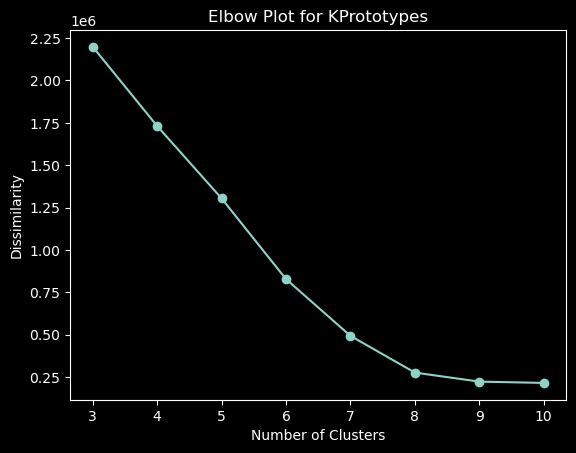

In [6]:
# Initialize cost list
cost = []

# Iterate for different amounts of centroids
for k in tqdm(range(3,11)):
    # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
    KProto = KPrototypes(n_clusters = k, init = 'Cao', n_init = 10, gamma = 0.3,  verbose = 0)
    # Use the KPrototypes model on the actual data
    cluster_labels = KProto.fit_predict(X, categorical = cat_col_index)
    # Append cost to the cost list for graphing later
    cost.append(KProto.cost_) 

# An elbow plot of k vs the cost function to try to find the optimal k
plt.plot(range(3,11), cost, marker = 'o');
# Label the x-axis
plt.xlabel('Number of Clusters');
#label the y-axis
plt.ylabel('Dissimilarity');
#Give the plot a title
plt.title('Elbow Plot for KPrototypes');

In [ ]:
# Make the clusters into a single column df for easy concatenation
clusters = pd.DataFrame({'K=8':cluster_labels})
# Combine the clusters and the features
c_f = pd.concat([X, clusters], axis = 1)

# Save this so that I don't have to keep running the clusters over and over again.
c_f.to_csv('./data/processed/Cluster_features.csv')


In [ ]:
cluster_labels = pd.read_csv('./data/processed/Cluster_features.csv')['K=8']
cluster_labels = cluster_labels.drop('Unnamed: 0', axis = 1)

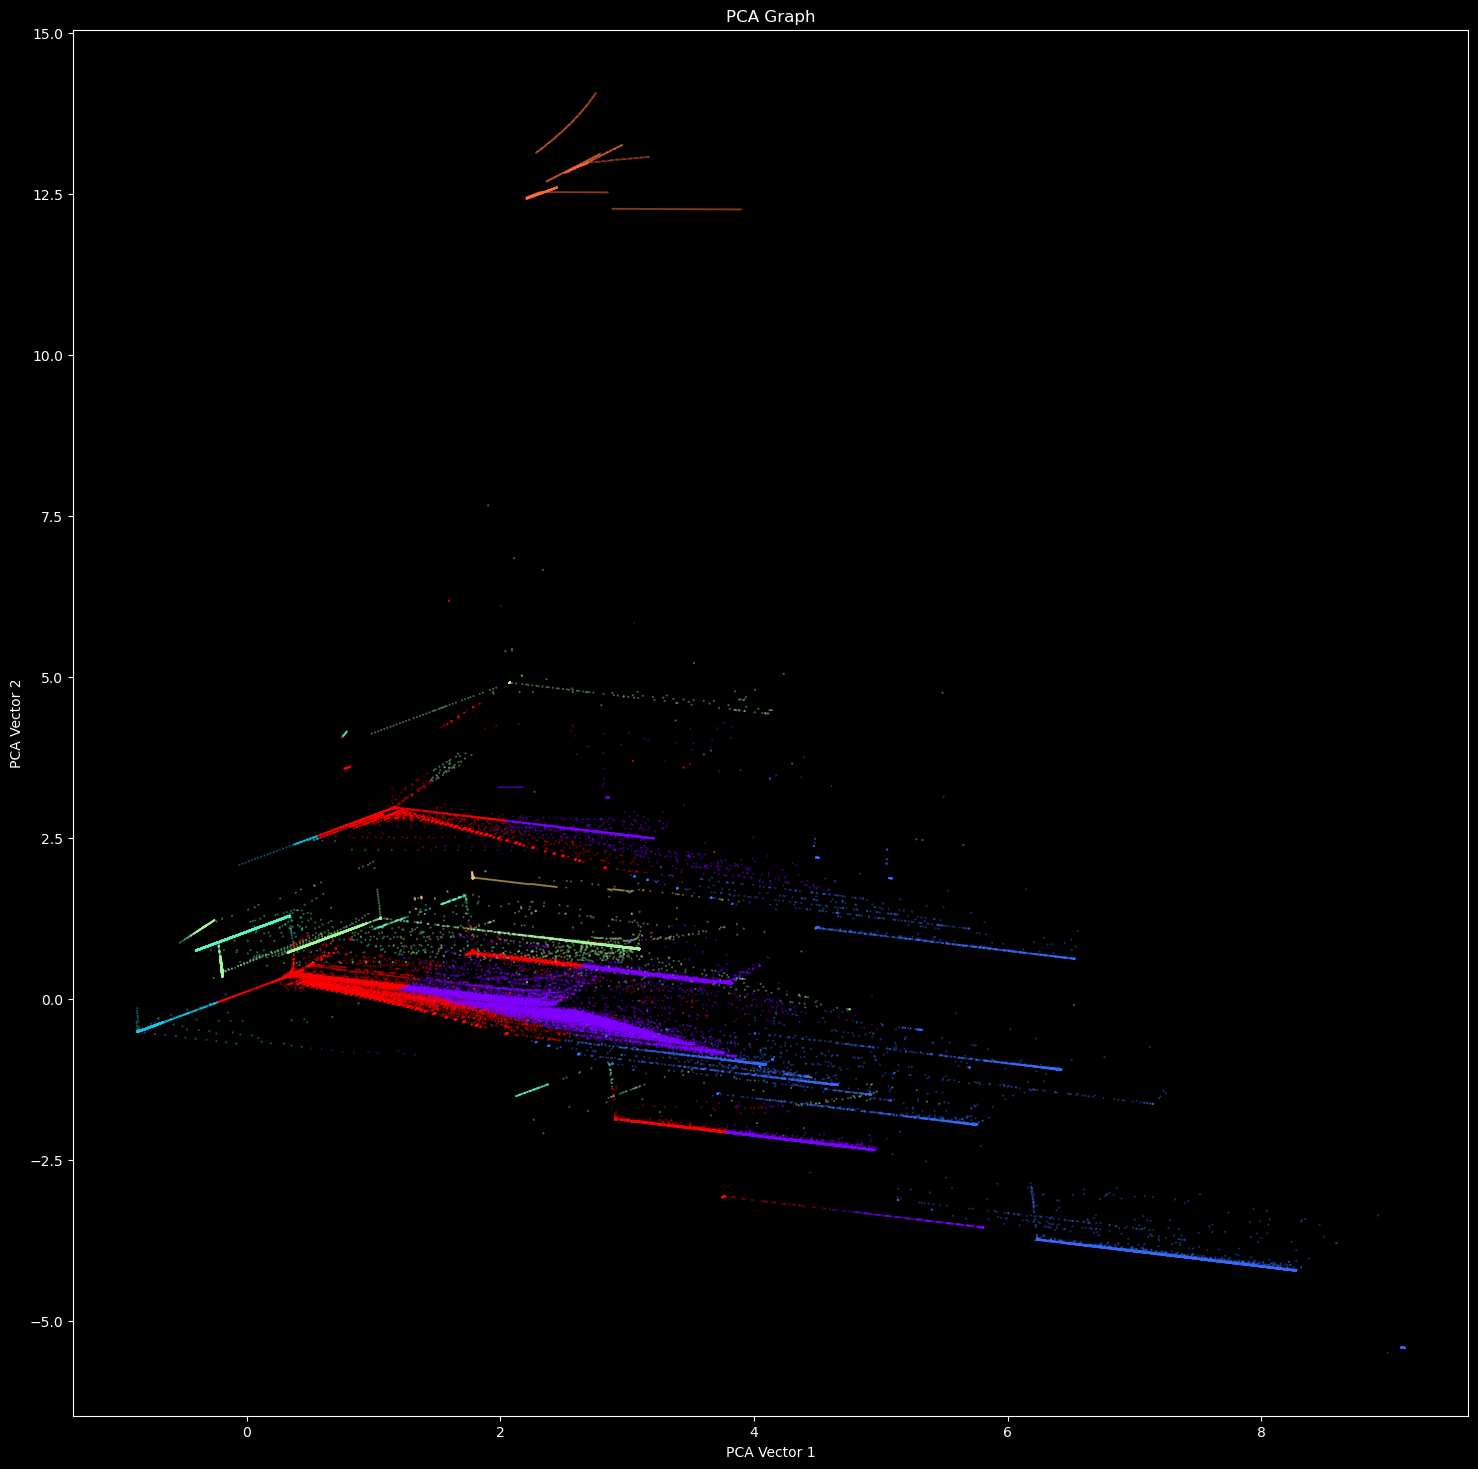

In [90]:
# Create the PCA object since the data has already been scaled
pca = PCA(n_components = 2)
# fit the data
pca_vectors = pca.fit_transform(X)

fig = plt.figure(figsize = (18, 18));
# Create a scatter plot representing the PCA transformation
plt.scatter(pca_vectors[:,0], pca_vectors[:,1], 
            c = cluster_labels, cmap = 'rainbow',
            s = 0.3, alpha = 0.4);
# Label the axes in the graph
plt.xlabel('PCA Vector 1');
plt.ylabel('PCA Vector 2');
# Give the plot a title
plt.title('PCA Graph');


In [91]:
# Import the features
c_f = pd.read_csv('./data/processed/Cluster_features.csv')
c_f = c_f.drop('Unnamed: 0', axis = 1)
c_f.head()

,wrong_fragment,hot,count,srv_diff_host_rate,dst_host_count,protocol_type_udp,service_eco_i,service_ftp_data,service_smtp,flag_RSTR,Syn Error,Rej Error,K=8
0,-0.04772,-0.044136,-1.521422,-0.203633,-3.297128,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
1,-0.04772,-0.044136,-1.521422,-0.203633,-3.142675,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
2,-0.04772,-0.044136,-1.530805,-0.203633,-2.988222,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
3,-0.04772,-0.044136,-1.530805,-0.203633,-2.833769,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
4,-0.04772,-0.044136,-1.530805,-0.203633,-2.679316,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0


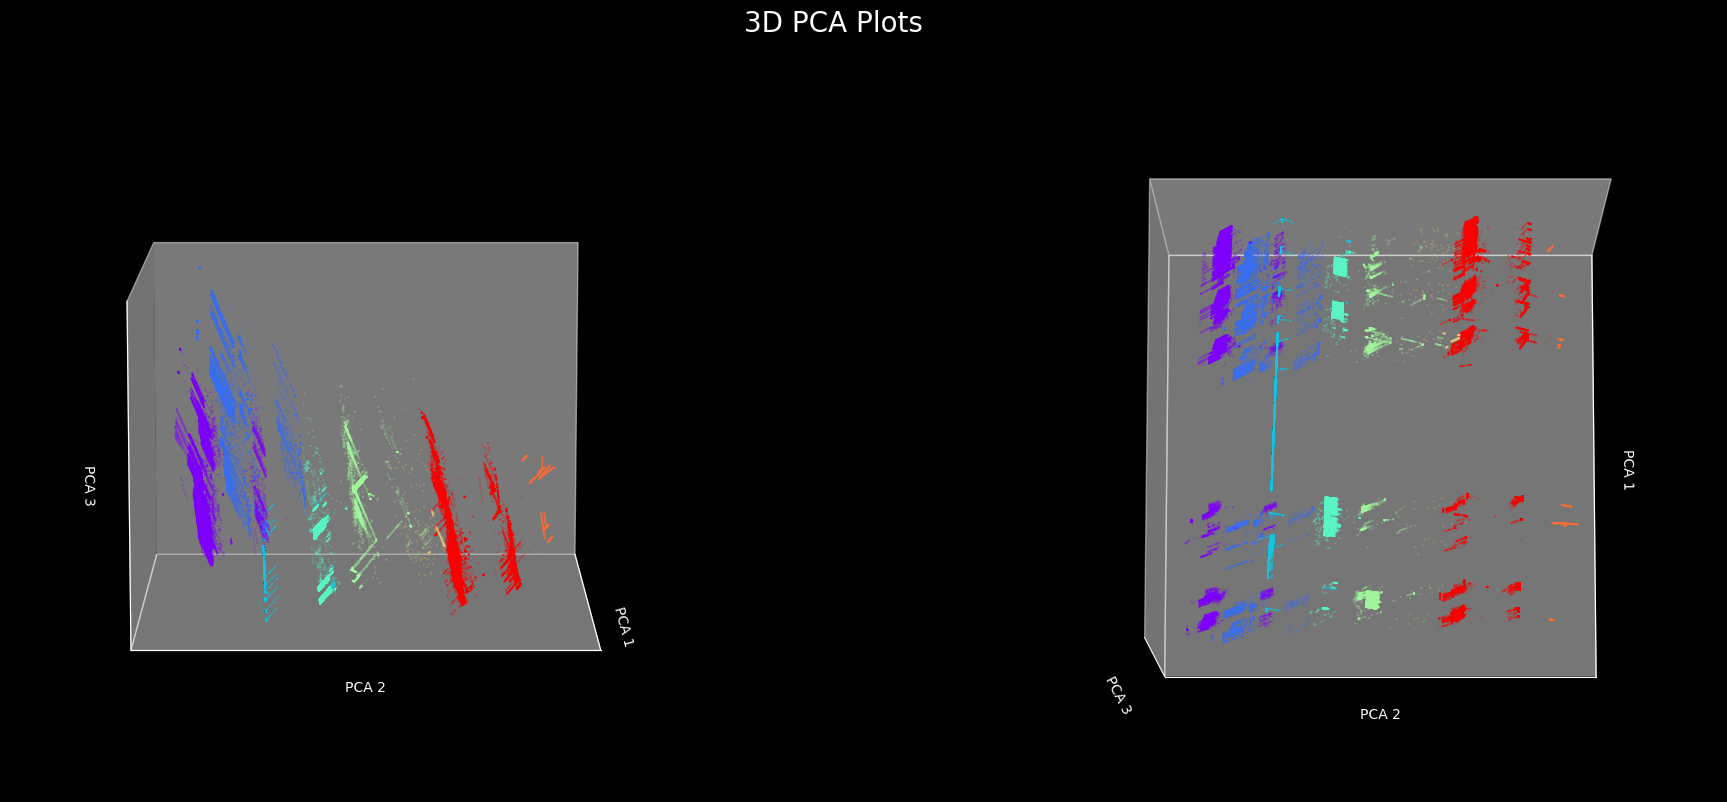

In [34]:

# Create the PCA object since the data has already been scaled
pca = PCA(n_components = 3)
# fit the data
pca_vectors = pca.fit_transform(c_f)

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'), figsize = (24,9))
for i in range(2):
    ax[i].scatter(xs=pca_vectors[:,0], ys=pca_vectors[:,1], zs=pca_vectors[:,2], 
                       c=c_f['K=8'], s=.1, cmap='rainbow', alpha=.4) 
    ax[i].set_xlabel('PCA 1', labelpad = .1)
    ax[i].set_ylabel('PCA 2', labelpad = .1)
    ax[i].set_zlabel('PCA 3', labelpad = .1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_zticks([])


ax[0].view_init(elev=10, azim=0)
ax[1].view_init(elev=1000, azim=180)

legend_labels = [i for i in range(1,9)]


plt.suptitle('3D PCA Plots', fontsize = 20)

plt.show()

    Now that I have generated clusters and labeled each observation, I need a way to validate the existence of a clustered structure in the data. The most straightforward way to evaluate the structure is a silhouette score which measures the distance or dissimilarity from other cluster's centroids (center of the cluster) compared to the dissimilarity to its own centroid. The closer a point is to its own centroid, while being far away from other centroids, the clearer it is that the structure is clustered. Unfortunately, when I ran the computation in R, the dataset was so large that the dissimilarity matrix (store of all the distances) returned a 900+ GB vector. That is far outside the ability of my computer or any normal commercial computer to handle. Even if I were to use just a tenth of the dataset for a representative sample, that would still generate a 9+ GB vector. As such I have to use different algorithms that are not as direct but can still lend some insight into validity of the clustering structure. 

The algorithms that I chose are the: 

#### **<center> Adjusted Rand Index (ARI) </center>**

$$
\mathrm{ARI}(true, new) = \mathrm{ADJ}(\frac{Matching Pairs}{Total Pairs}) 
$$
- Where true is the "true value of the clusters, 
- new is the dataset it is being compared to, 
- A pair is each combination of cluster labels from the true, and new datasets, 
- ADJ is the adjustment, it corrects for the amount of pairs that will match out of pure chance
    
#### **<center> Normalized Mutual Index (NMI) </center>** 

$$
NMI = \frac{2 * I(true, new)}{H(true) + H(new)}
$$
- true: ibid
- new: ibid
- I(true, new) is a function that measure how much the two cluster sets have in common
- H(true) and H(new) are the entropy of the cluster labels. More simply it measures the distribution
    of clusters over the data. The more evenly distributed the clusters, the higher the entropy

#### **<center> Fowlkes-Mallow Index (FMI) </center>**

$$
\text{FMI} = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}}
$$
- TP is the number of pairs that have the same cluster label as the first set of labels,
- FP is the number of pairs that have the same cluster label as the second set of labels

The ARI measures the similarity between two sets of labels on a scale of -1 to 1 where negative values indicate clear difference and 1 is a perfect match. NMI and FMI are from 0 to 1 and also measure similarity. To test the structure of this dataset, I can take a representative sample, run the clustering algorithm on the sample and then compare the sample's clusters to the full dataset's labels. If there are no clusters and the data is random, then I will get two very different sets of labels that will have low similarity scores. I don't have a clear threshhold to determine if there are clusters in the data but the closer the scores are to 1, the higher the likelihood that the data has a clustered structure.

I ran the tests for K values 6 to 8 to evaluate what the best value of K is. The higher the scores, the better the value of K must be. I ran each of the algorithms five times on new samples and then averaged results to obtain the similarity scores.

In [42]:
# Initialize Rand Index, Normalized Mutual Index, Fowlkes-Mallow
Rand, NMi, FMi = [], [], []

for i in tqdm(range(5)):
    # Create Bootstrap dataset with the same index as before so that I can find the original clusters as well
    bootstrap = X.sample(frac = 0.2, replace = True)
    # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
    KProto = KPrototypes(n_clusters = 8, init = 'random', gamma = 0.3, n_init = 10, verbose = 0, n_jobs = -1)
    # Use the KPrototypes model on the actual data
    bootstrap_labels = KProto.fit_predict(bootstrap, categorical = cat_col_index)
    # Create Original Dataset's lables for bootstrapped data
    orig_value = [c_f['K=8'][i] for i in bootstrap.index]
    # Rand index calculation
    Rand.append(adjusted_rand_score(orig_value, bootstrap_labels))
    # Normalized Mutual index calculation
    NMi.append(normalized_mutual_info_score(orig_value, bootstrap_labels))
    # Fowlkes Mallow Index calculation
    FMi.append(fowlkes_mallows_score(orig_value, bootstrap_labels))



100%|██████████| 5/5 [10:03<00:00, 120.61s/it]

Adjusted Rand Index: 0.9999666573803745     Normalized Mutual Index: 0.9996983085994436     Fowlkes Mallow Index: 0.9999790796948297


In [43]:
# Print out the results for each Value of K
print(f"Adjusted Rand Index: {np.mean(Rand)}     Normalized Mutual Index: {np.mean(NMi)}     Fowlkes Mallow Index: {np.mean(FMi)}")

Adjusted Rand Index: 0.9999666573803745     Normalized Mutual Index: 0.9996983085994436     Fowlkes Mallow Index: 0.9999790796948297


I wasn't conviced that the similarity scores are valid proofs for the existence of a structure. As such I created a completely random dataset and ran the same test as above to see what would happen if there were no clusters. Since all of the scores were significantly lower than my dataset, this method is solid.

In [44]:
# Test a random dataset's similarity score
# set random seed for reproducibility
np.random.seed(123)

# create categorical columns
cat_col1 = pd.Series(np.random.choice(['A', 'B', 'C'], size=1000))
cat_col2 = pd.Series(np.random.choice(['X', 'Y', 'Z'], size=1000))

# create numerical columns
num_cols = pd.DataFrame(np.random.randn(1000, 8), columns=['Num1', 'Num2', 'Num3', 'Num4', 'Num5', 'Num6', 'Num7', 'Num8'])

# concatenate categorical and numerical columns
df = pd.concat([cat_col1, cat_col2, num_cols], axis=1)

# set column names for categorical columns
df.columns = ['Cat1', 'Cat2', 'Num1', 'Num2', 'Num3', 'Num4', 'Num5', 'Num6', 'Num7', 'Num8']

# Perform the clustering for the dataset
KProto = KPrototypes(n_clusters = 8, init = 'cao', n_init = 10, verbose = 0)
# Use the KPrototypes model on the actual data
labels = KProto.fit_predict(df, categorical = [0,1])


# Create Bootstrap dataset with the same index as before so that I can find the original clusters as well
bootstrap = df.sample(frac = 0.2, replace = True)

# Re run the clustering for the sample
KProto = KPrototypes(n_clusters = 8, init = 'random', n_init = 10, verbose = 0)
# Use the KPrototypes model on the actual data
bootstrap_labels = KProto.fit_predict(bootstrap, categorical = [0,1])

# Create Original Dataset's lables for bootstrapped data
orig_value = [labels[i] for i in bootstrap.index]

# Rand index calculation
Rand = adjusted_rand_score(orig_value, bootstrap_labels)

# Normalized Mutual index calculation
NMi = normalized_mutual_info_score(orig_value, bootstrap_labels)

# Fowlkes Mallow Index calculation
FMi = fowlkes_mallows_score(orig_value, bootstrap_labels)

print(f"Adjusted Rand Index: {Rand}")
print(f"Normalized Mutual Index: {NMi}")
print(f"Fowlkes Mallow Index: {FMi}")

Adjusted Rand Index: 0.18599893493315675
Normalized Mutual Index: 0.34959850252909774
Fowlkes Mallow Index: 0.289448260165949


## Cluster Analysis

Now that we have cluster labels, we can see how those cluster labels interact with different types of intrusions. First, I plotted a histogram of different types of intrusions and colored each observation with the its cluster. Hopefully the different intrusion types fully belong to a single clusters, although if the graph isn't that clean, there are still other ways to analyze the clusters.

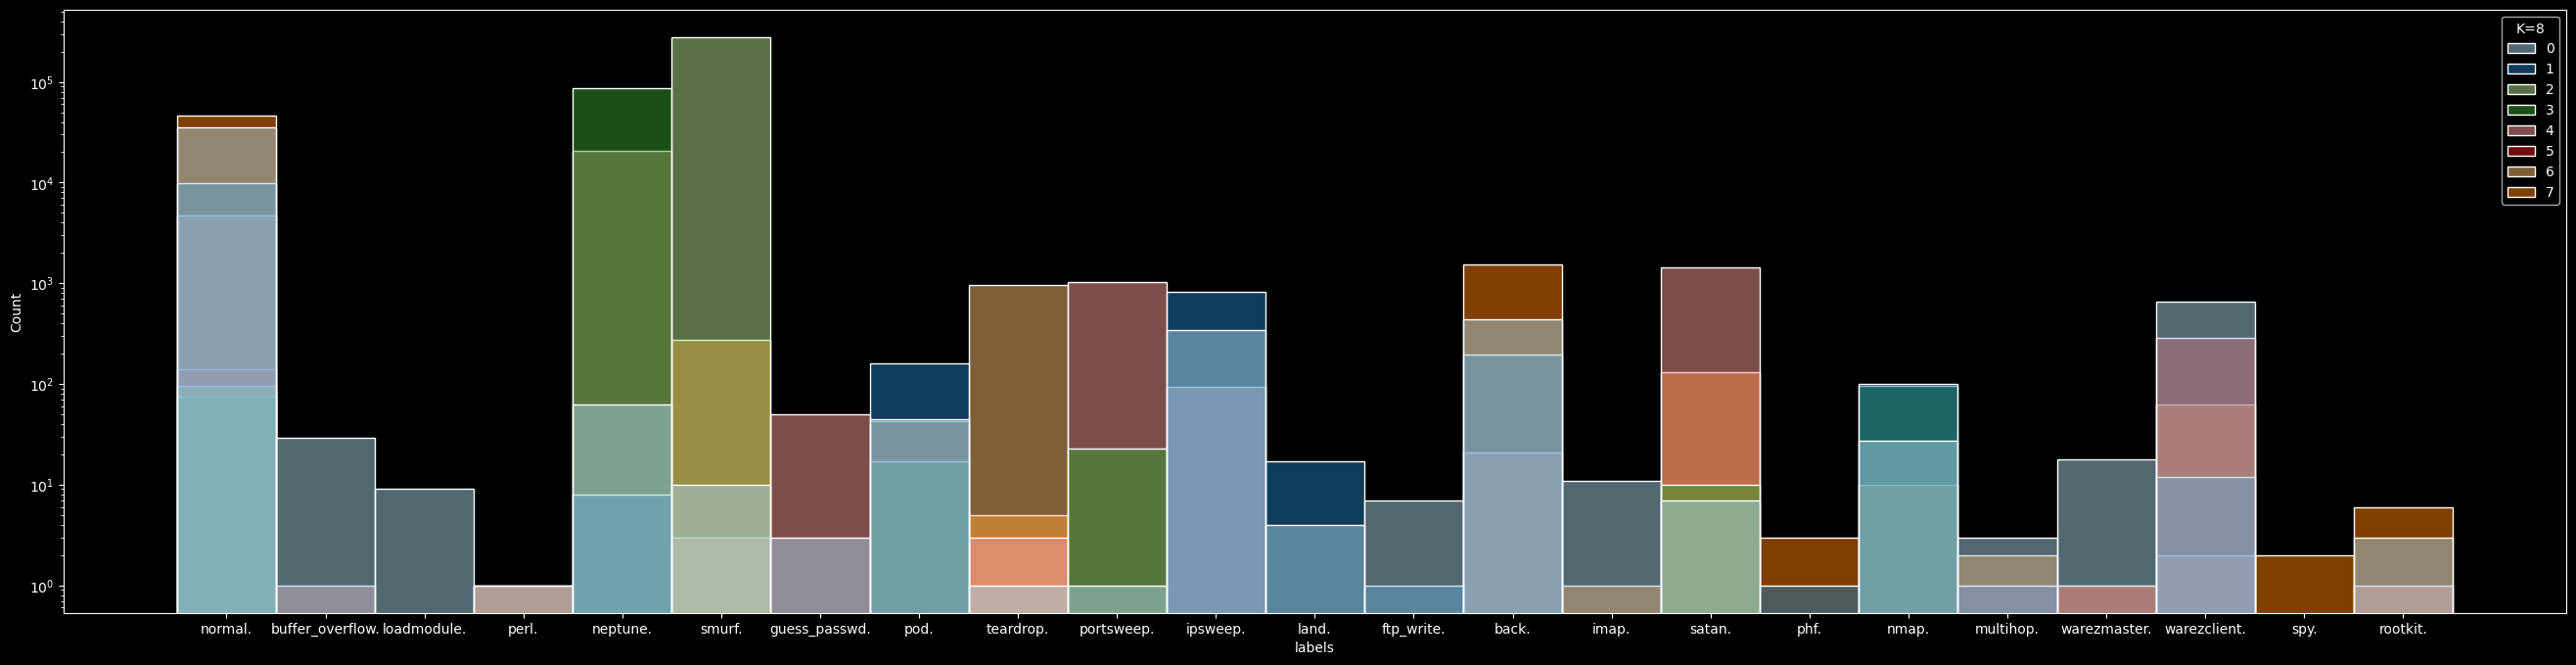

smurf.              0.568378
neptune.            0.216997
normal.             0.196909
back.               0.004459
satan.              0.003216
ipsweep.            0.002524
portsweep.          0.002105
warezclient.        0.002065
teardrop.           0.001982
pod.                0.000534
nmap.               0.000468
guess_passwd.       0.000107
buffer_overflow.    0.000061
land.               0.000043
warezmaster.        0.000040
imap.               0.000024
rootkit.            0.000020
loadmodule.         0.000018
ftp_write.          0.000016
multihop.           0.000014
phf.                0.000008
perl.               0.000006
spy.                0.000004
Name: labels, dtype: float64


In [57]:
#Switch back to dark mode for my eyes
plt.style.use('dark_background')

# Change figure size so that the x tick marks are readable
plt.figure(figsize = (33,8))

# Create a histogram of the types of network intrusions including non-intrusions
sns.histplot(data = data, x = 'labels', hue = cluster_labels, palette = 'Paired')

# Set the scale to log so that we can have a much better visualization of the attacks
plt.yscale('log')

plt.show()

# Give context to how much each intrusion occurs
print(data['labels'].value_counts(normalize = True))

Unfortunately, each intrusion has many different clusters inside of it but there is still a lot of analysis to be done. One possibility is to examine the frequency of a cluster's normal observations and the severity of the attacks it contains. 

Before any of that, I will create a correlation matrix to better visualize clear relationships between the clusters and the attack types. If there is, it will give us interesting options to pursue.

In [85]:
# import the data with K=8
dataK8 = pd.concat([data['labels'], cluster_labels], axis = 1)

#Create a dummy matrix for the types of intrusions and labels
lab_clus_dummy = pd.get_dummies(dataK8, columns = ['labels', 'K=8'], 
                                # No prefix to make the graph look better
                                prefix = ['label', 'cluster'], 
                                # No sep to make the graph look better
                                prefix_sep = '_')

lab_clus_dummy.columns

Index(['label_back.', 'label_buffer_overflow.', 'label_ftp_write.',
       'label_guess_passwd.', 'label_imap.', 'label_ipsweep.', 'label_land.',
       'label_loadmodule.', 'label_multihop.', 'label_neptune.', 'label_nmap.',
       'label_normal.', 'label_perl.', 'label_phf.', 'label_pod.',
       'label_portsweep.', 'label_rootkit.', 'label_satan.', 'label_smurf.',
       'label_spy.', 'label_teardrop.', 'label_warezclient.',
       'label_warezmaster.', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'],
      dtype='object')

100%|██████████| 8/8 [00:01<00:00,  6.49it/s]


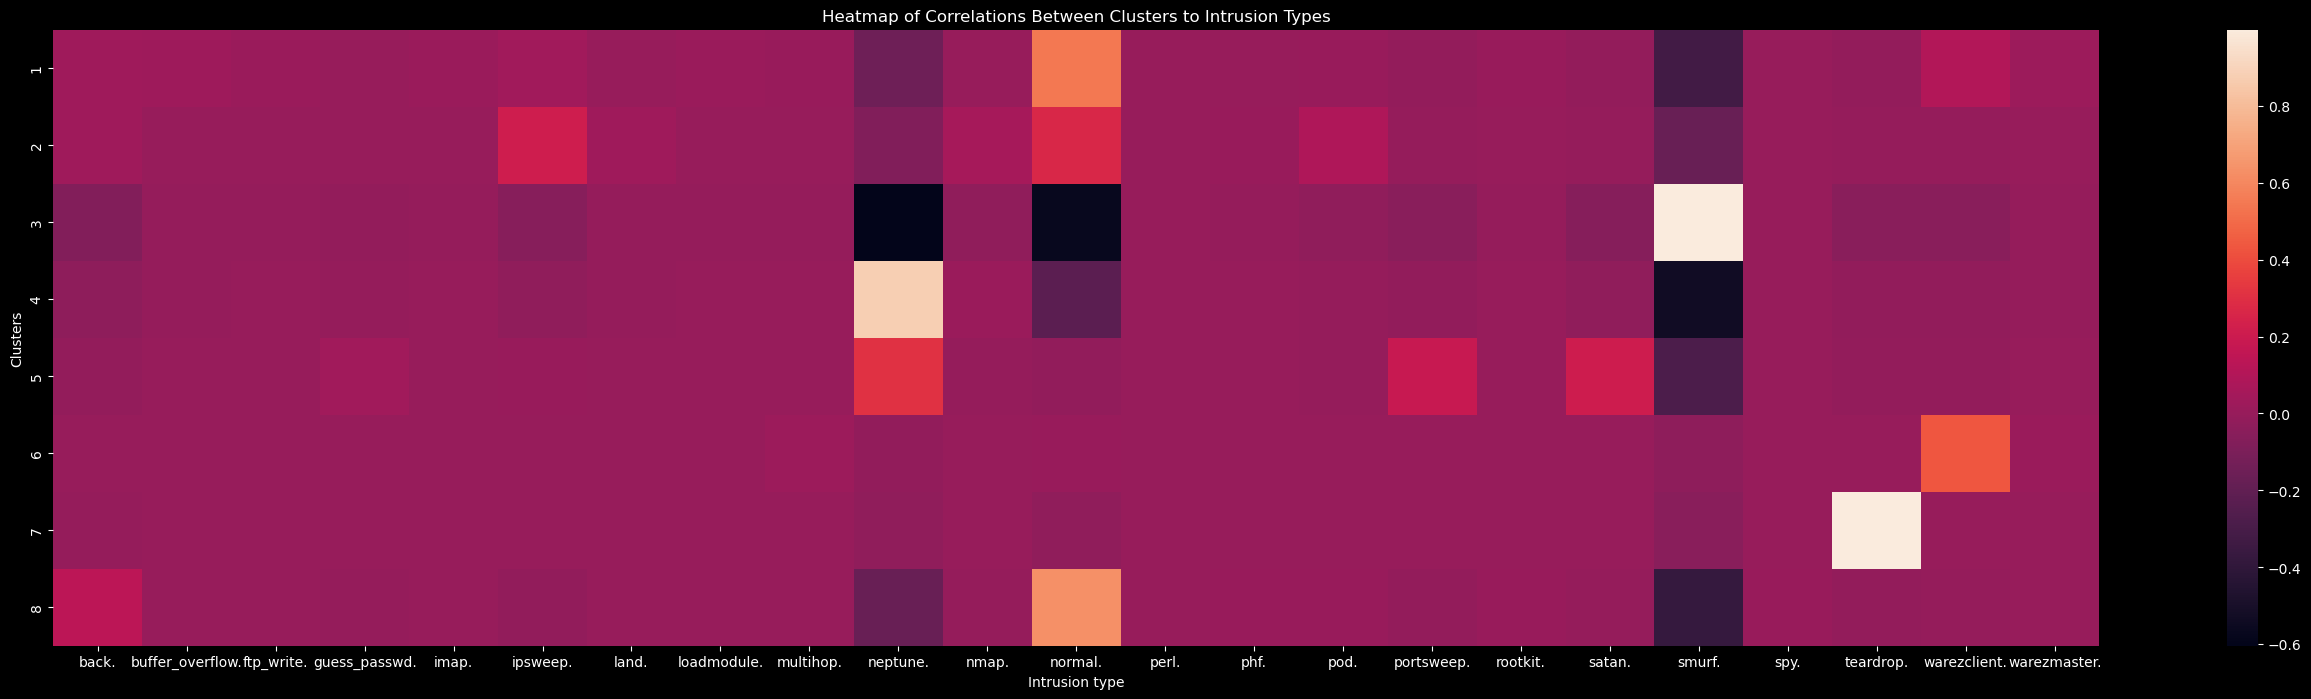

In [63]:
# create a matrix that stores each of the correlations between the clusters and labels
corr_matrix = np.zeros((23,8))

# loop over the clusters
for k in tqdm(range(23, len(lab_clus_dummy.columns))):
    # Loop over the different labels
    for label in range(23):
        # Assign each part of the matrix the correlation between label and cluster
        corr_matrix[label, k-23] = lab_clus_dummy.iloc[:,k].T.corr(other = lab_clus_dummy.iloc[:,label])


# Turn the correlation matrix into a dataframe so it will be easier to manipulate
corr_df = pd.DataFrame(corr_matrix, 
                       columns = range(1,9),
                       index = lab_clus_dummy.columns[:23])



#Back to darkmode for the eyes
plt.style.use('dark_background')
# Change the figure size so that all the intrusions types are legible
plt.figure(figsize = (33,8))
# Create a heatmap of correlation matrix to see each clusters highest intrusion correlations
sns.heatmap(corr_df.T);
# Label the axes
plt.xlabel('Intrusion type');
plt.ylabel('Clusters');
# Give a title
plt.title('Heatmap of Correlations Between Clusters to Intrusion Types');

In [107]:
lab_clus_dummy.loc[lab_clus_dummy['label_teardrop.'] == 1, 'cluster_6'].value_counts()

1    970
0      9
Name: cluster_6, dtype: int64

From this graph it is clear that some of the clusters have strong correlations to some of the label types. When we reexamine the value counts from the previous code box, we can see that neptune, normal, and smurf accoung for over 98 percent of the dataset. Not only does it make sense that they are the only columns that have real correlation, but if we can prevent those two attacks we will have provided significant value.

We next will create a heatmap with just those attack types and group the rest of the intrusions as 

100%|██████████| 8/8 [00:00<00:00, 30.03it/s]


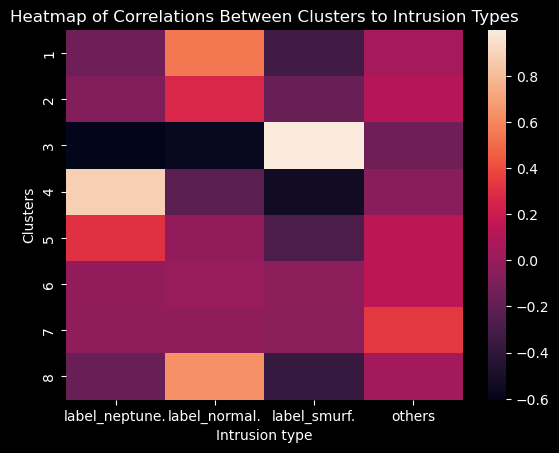

In [87]:
# Separate out the clusters
lab_dummy = lab_clus_dummy.filter(like = 'label')
# Separate out neptune, normal, and smurf
others = list(set(lab_dummy.columns) - set(['label_neptune.','label_normal.','label_smurf.']))
# Create a column that has 1 for every other column
lab_clus_dummy['others'] = lab_dummy[others].sum(axis = 1)

# only others, normal and 2 intrusion types, clusters
cons_df = pd.concat([lab_clus_dummy[['label_neptune.','label_normal.','label_smurf.']],
                     lab_clus_dummy['others'], 
                     lab_clus_dummy.filter(like = 'cluster')],
                     axis = 1)

# Use the same code that was used to generate the correlation heatmap
corr_matrix_cons = np.zeros((4,8))

# loop over the clusters
for k in tqdm(range(4, len(cons_df.columns))):
    # Loop over the different labels
    for label in range(4):
        # Assign each part of the matrix the correlation between label and cluster
        corr_matrix_cons[label, k-4] = cons_df.iloc[:,k].T.corr(other = cons_df.iloc[:,label])

# Turn the correlation matrix into a dataframe so it will be easier to manipulate
corr_df_cons = pd.DataFrame(corr_matrix_cons, 
                       columns = range(1,9),
                       index = cons_df.columns[:4])

#Back to darkmode for the eyes
plt.style.use('dark_background')
# Change the figure size so that all the intrusions types are legible
plt.figure(figsize = (8,1))
# Create a heatmap of correlation matrix to see each clusters highest intrusion correlations
sns.heatmap(corr_df_cons.T);
# Label the axes
plt.xlabel('Intrusion type');
plt.ylabel('Clusters');
# Give a title
plt.title('Heatmap of Correlations Between Clusters to Intrusion Types');


With this graph we can see that the clusters have clear predictive ability. The first three columns in the heatmap make up over 98 percent of the dataset so if there are insights to be made about these three labels than we can provide valuable insight on the project. The most obvious step is to investigate what makes these clusters interesting. By using groupby we can see if any categories stand out.

In [111]:
clustered = c_f.groupby('K=8').mean()
scaler = StandardScaler()
scaler.fit(clustered)
clustered_scaled = pd.DataFrame(scaler.transform(clustered), columns = X.columns)
clustered_scaled

,wrong_fragment,hot,count,srv_diff_host_rate,dst_host_count,protocol_type_udp,service_eco_i,service_ftp_data,service_smtp,flag_RSTR,Syn Error,Rej Error
0,-0.379229,-0.374794,-0.674132,-0.243461,-1.961406,-0.473884,0.098222,2.422298,0.195301,-0.358550,-0.411341,-0.505953
1,-0.366100,-0.376137,-0.710640,2.639208,-1.347271,-0.203720,2.600395,0.026239,2.569442,-0.337942,-0.398801,-0.144752
2,-0.380339,-0.380867,2.391084,-0.428401,0.833635,-0.572043,-0.471785,-0.635033,-0.521049,-0.410923,-0.432267,-0.533122
3,-0.380141,-0.380860,0.441740,-0.428127,0.831560,-0.573080,-0.471785,-0.556225,-0.510568,-0.410923,2.638032,-0.532477
4,-0.380229,-0.380415,0.267179,-0.423297,0.298327,-0.568113,-0.471785,-0.547010,-0.497022,2.643791,-0.392555,2.573699
5,-0.380339,2.645738,-0.712910,-0.412457,0.034495,-0.573080,-0.471785,-0.635033,-0.521049,-0.410923,-0.397486,-0.491636
6,2.645724,-0.380867,-0.349221,-0.428402,0.622150,2.490596,-0.471785,-0.635033,-0.521049,-0.410923,-0.179851,0.150877
7,-0.379347,-0.371796,-0.653100,-0.275062,0.688511,0.473324,-0.339692,0.559798,-0.194007,-0.303606,-0.425731,-0.516636


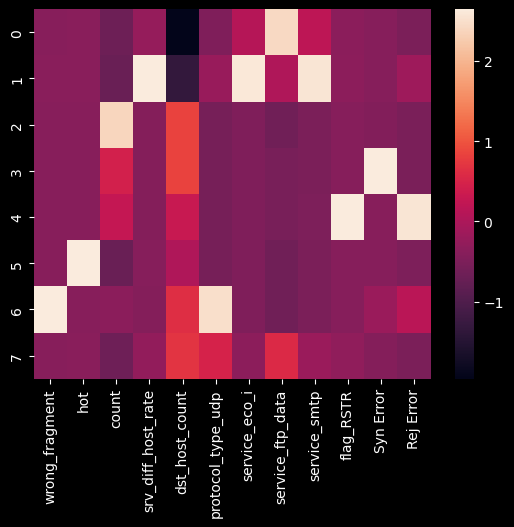

In [112]:
sns.heatmap(clustered_scaled);

In [113]:
c_f.head()

,wrong_fragment,hot,count,srv_diff_host_rate,dst_host_count,protocol_type_udp,service_eco_i,service_ftp_data,service_smtp,flag_RSTR,Syn Error,Rej Error,K=8
0,-0.04772,-0.044136,-1.521422,-0.203633,-3.297128,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
1,-0.04772,-0.044136,-1.521422,-0.203633,-3.142675,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
2,-0.04772,-0.044136,-1.530805,-0.203633,-2.988222,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
3,-0.04772,-0.044136,-1.530805,-0.203633,-2.833769,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
4,-0.04772,-0.044136,-1.530805,-0.203633,-2.679316,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961,0
